# Liesel-GAM Demo Notebook

## Setup and Imports

In [62]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [63]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

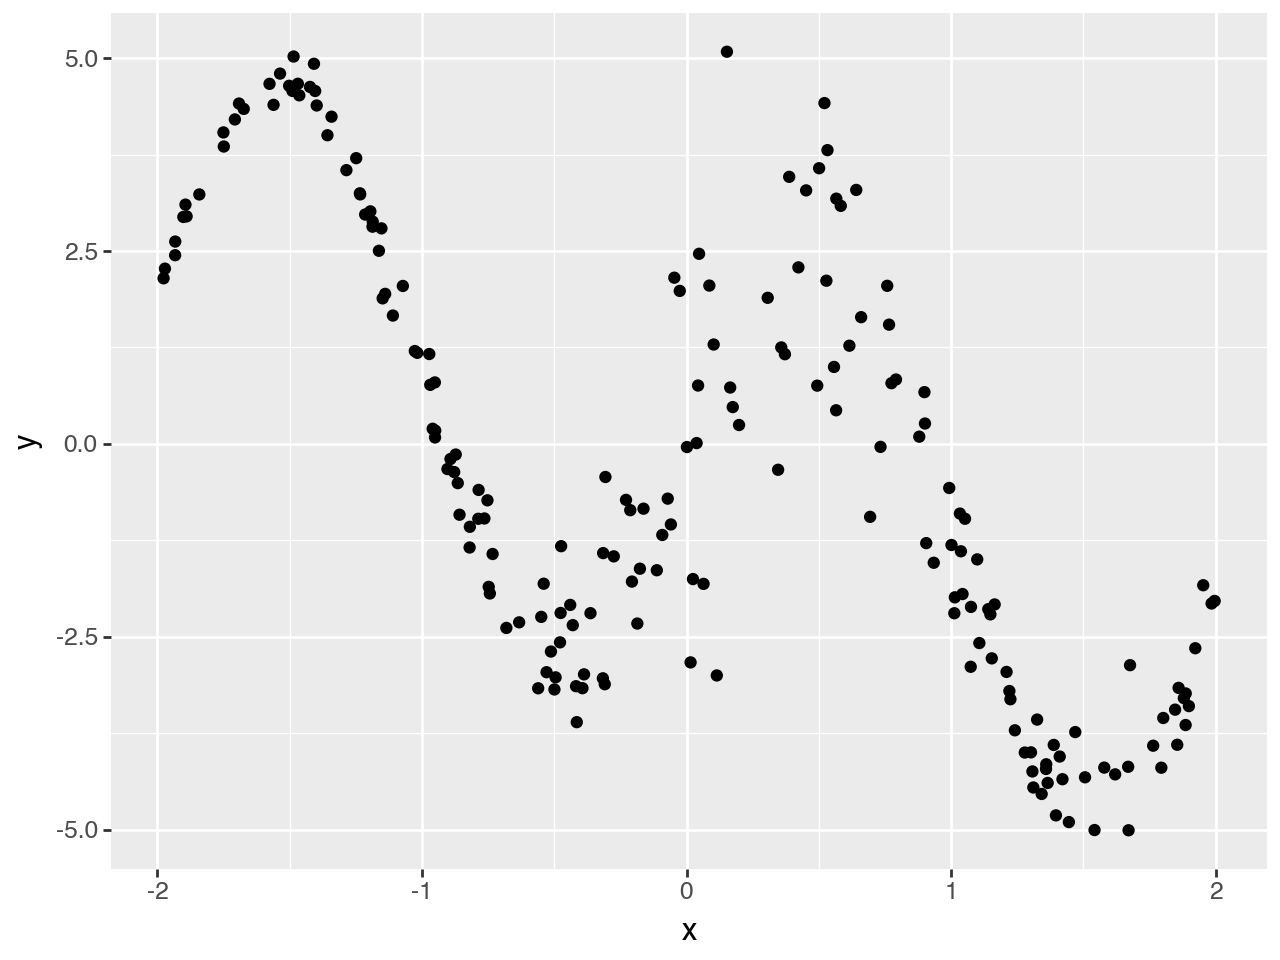

In [64]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [65]:
loc = gam.AdditivePredictor("loc")
scale = gam.AdditivePredictor("scale", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)


registry = gam.PandasRegistry(df)
tbl = gam.TermBuilder(registry, prefix_names_by="loc.")
tbs = gam.TermBuilder(registry, prefix_names_by="scale.")

loc += tbl.ps("x", k=20)
scale += tbs.ps("x", k=20)

### Build and plot model

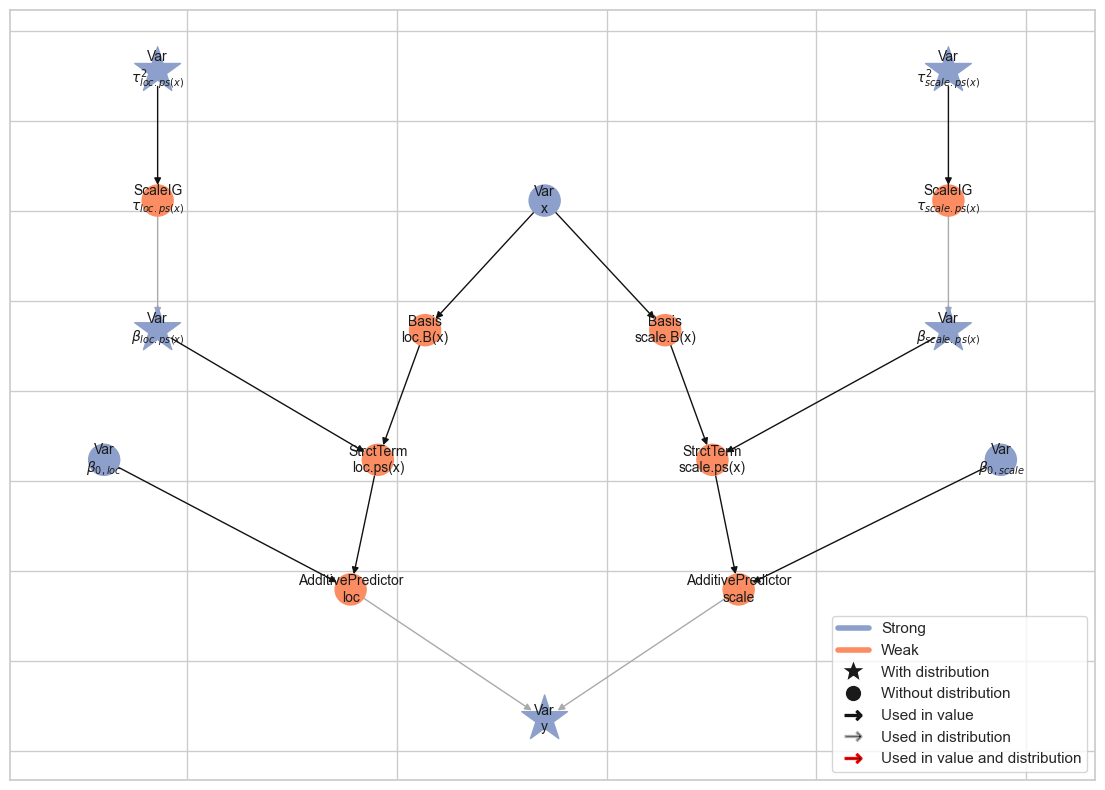

In [66]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [67]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,scale}$', '$\\beta_{scale.ps(x)}$', '$\\tau_{scale.ps(x)}^2$', '$\\beta_{0,loc}$', '$\\beta_{loc.ps(x)}$', '$\\tau_{loc.ps(x)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:04<00:00,  2.49chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [68]:
summary = gs.Summary(results)
summary

Parameter summary:

                                 kernel      mean        sd    q_0.05  \
parameter              index                                            
$\beta_{0,loc}$        ()     kernel_03 -0.319038  0.057453 -0.416217   
$\beta_{0,scale}$      ()     kernel_00 -0.628547  0.053395 -0.716780   
$\beta_{loc.ps(x)}$    (0,)   kernel_04  0.161261  0.337669 -0.384076   
                       (1,)   kernel_04 -0.138344  0.302521 -0.630288   
                       (2,)   kernel_04  0.146713  0.308337 -0.345811   
                       (3,)   kernel_04  0.160964  0.288147 -0.300860   
                       (4,)   kernel_04 -0.263484  0.283364 -0.745345   
                       (5,)   kernel_04  0.015893  0.268138 -0.417609   
                       (6,)   kernel_04  0.004710  0.250642 -0.404780   
                       (7,)   kernel_04  0.100612  0.229481 -0.277275   
                       (8,)   kernel_04  0.061738  0.218932 -0.292218   
                       (9,)   kernel_04  0.077538  0.185739 -0.225091   
                       (10,)  kernel_04  0.081112  0.171348 -0.199386   
                       (11,)  kernel_04 -0.046074  0.137781 -0.272303   
                       (12,)  kernel_04  0.073245  0.114179 -0.115116   
                       (13,)  kernel_04 -0.081454  0.087286 -0.220716   
                       (14,)  kernel_04  1.233195  0.065072  1.127220   
                       (15,)  kernel_04  0.024637  0.041575 -0.043272   
                       (16,)  kernel_04 -0.015318  0.021626 -0.050542   
                       (17,)  kernel_04  0.009640  0.009086 -0.005220   
                       (18,)  kernel_04 -0.422633  0.031430 -0.474029   
$\beta_{scale.ps(x)}$  (0,)   kernel_01  0.007240  0.077110 -0.111417   
                       (1,)   kernel_01 -0.012415  0.076543 -0.134162   
                       (2,)   kernel_01 -0.006512  0.076223 -0.136677   
                       (3,)   kernel_01 -0.002339  0.075638 -0.124186   
                       (4,)   kernel_01  0.005274  0.074501 -0.116537   
                       (5,)   kernel_01 -0.004010  0.077203 -0.129410   
                       (6,)   kernel_01  0.027981  0.077760 -0.092047   
                       (7,)   kernel_01  0.033006  0.076227 -0.083868   
                       (8,)   kernel_01  0.010721  0.071013 -0.103250   
                       (9,)   kernel_01 -0.012459  0.068011 -0.125237   
                       (10,)  kernel_01  0.014174  0.068428 -0.092293   
                       (11,)  kernel_01  0.006739  0.063275 -0.097802   
                       (12,)  kernel_01  0.068649  0.060233 -0.023281   
                       (13,)  kernel_01 -0.066065  0.050716 -0.152912   
                       (14,)  kernel_01  0.058462  0.041304 -0.008856   
                       (15,)  kernel_01  0.079148  0.029153  0.032444   
                       (16,)  kernel_01  0.005284  0.016620 -0.022161   
                       (17,)  kernel_01 -0.041883  0.007052 -0.053104   
                       (18,)  kernel_01  0.128246  0.027256  0.083433   
$\tau_{loc.ps(x)}^2$   ()     kernel_05  0.140607  0.060868  0.071566   
$\tau_{scale.ps(x)}^2$ ()     kernel_02  0.005986  0.004643  0.001914   

                                 q_0.5    q_0.95  sample_size     ess_bulk  \
parameter              index                                                 
$\beta_{0,loc}$        ()    -0.318389 -0.226010         4000   755.160850   
$\beta_{0,scale}$      ()    -0.629166 -0.538788         4000  3761.400457   
$\beta_{loc.ps(x)}$    (0,)   0.158211  0.713702         4000  3516.217015   
                       (1,)  -0.137469  0.333897         4000  3139.145645   
                       (2,)   0.137165  0.652972         4000  3514.173945   
                       (3,)   0.156749  0.643485         4000  3908.215895   
                       (4,)  -0.255425  0.192801         4000  3612.154260   
                       (5,)   0.015399  0.460677         4000  36

### MCMC trace plots

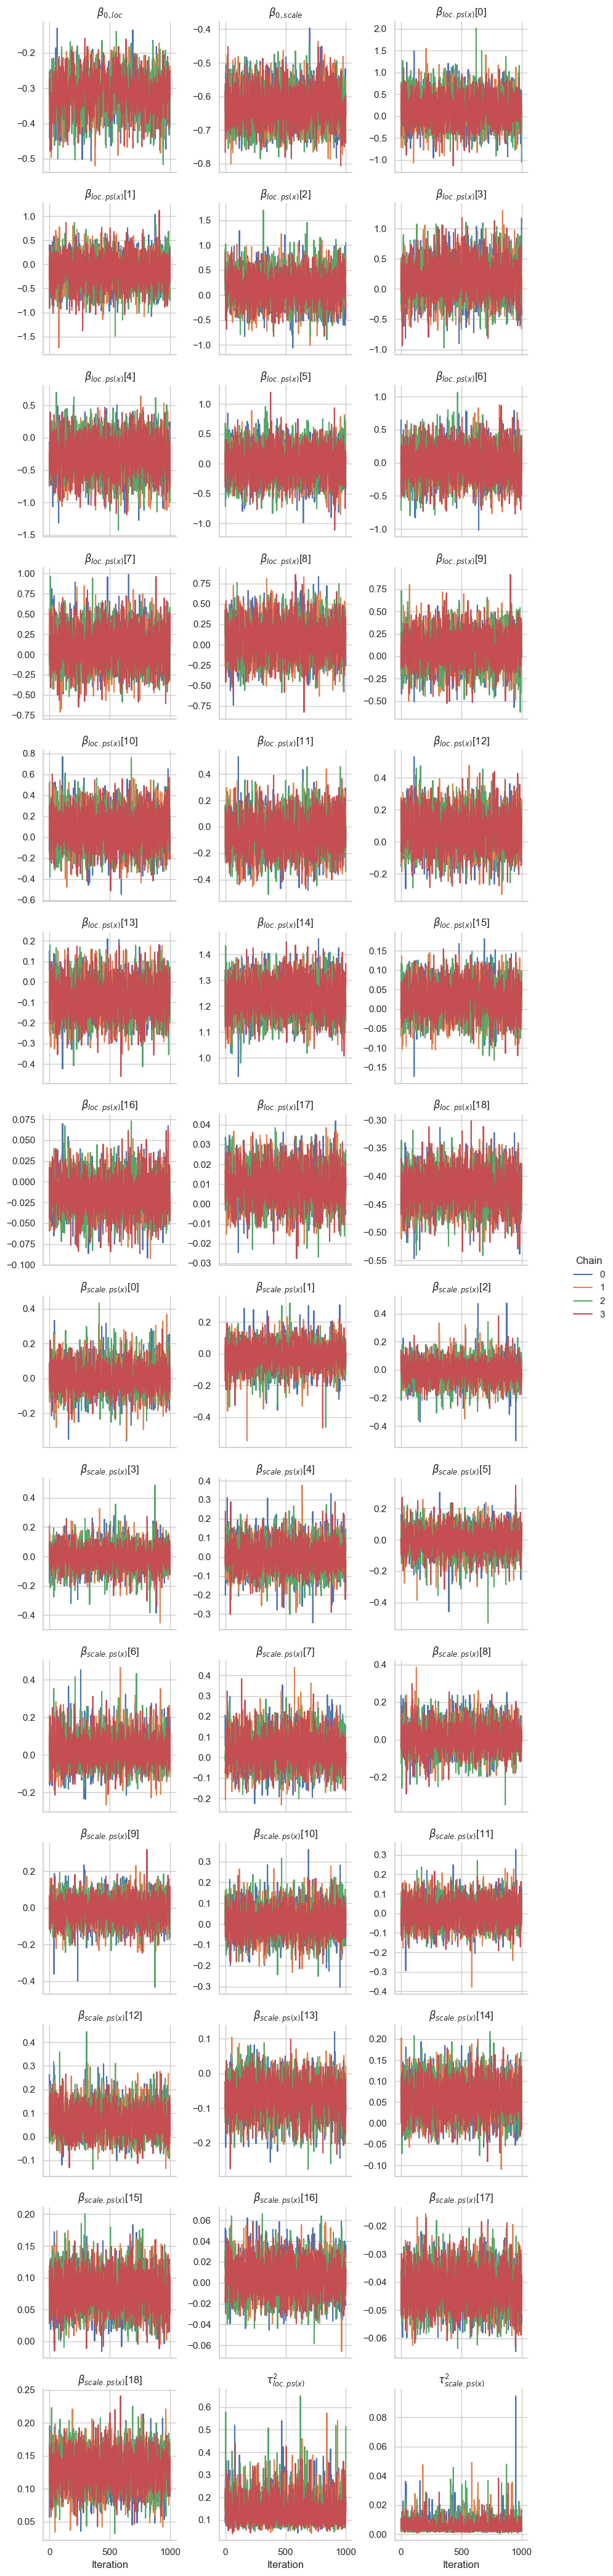

In [69]:
gs.plot_trace(results)

## Predictions

In [70]:
samples = results.get_posterior_samples()

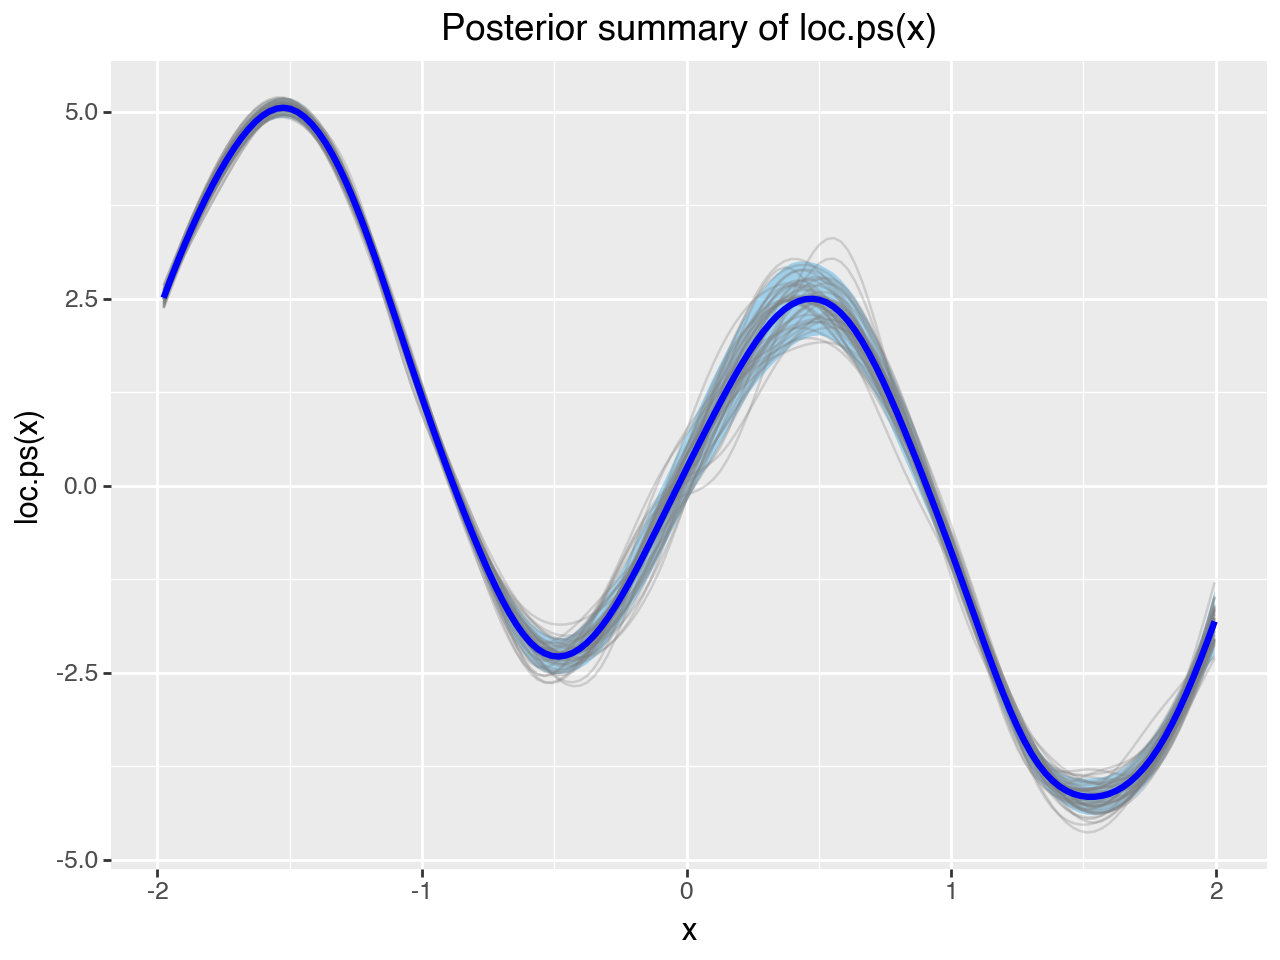

In [71]:
gam.plot_1d_smooth(term=model.vars["loc.ps(x)"], samples=samples)

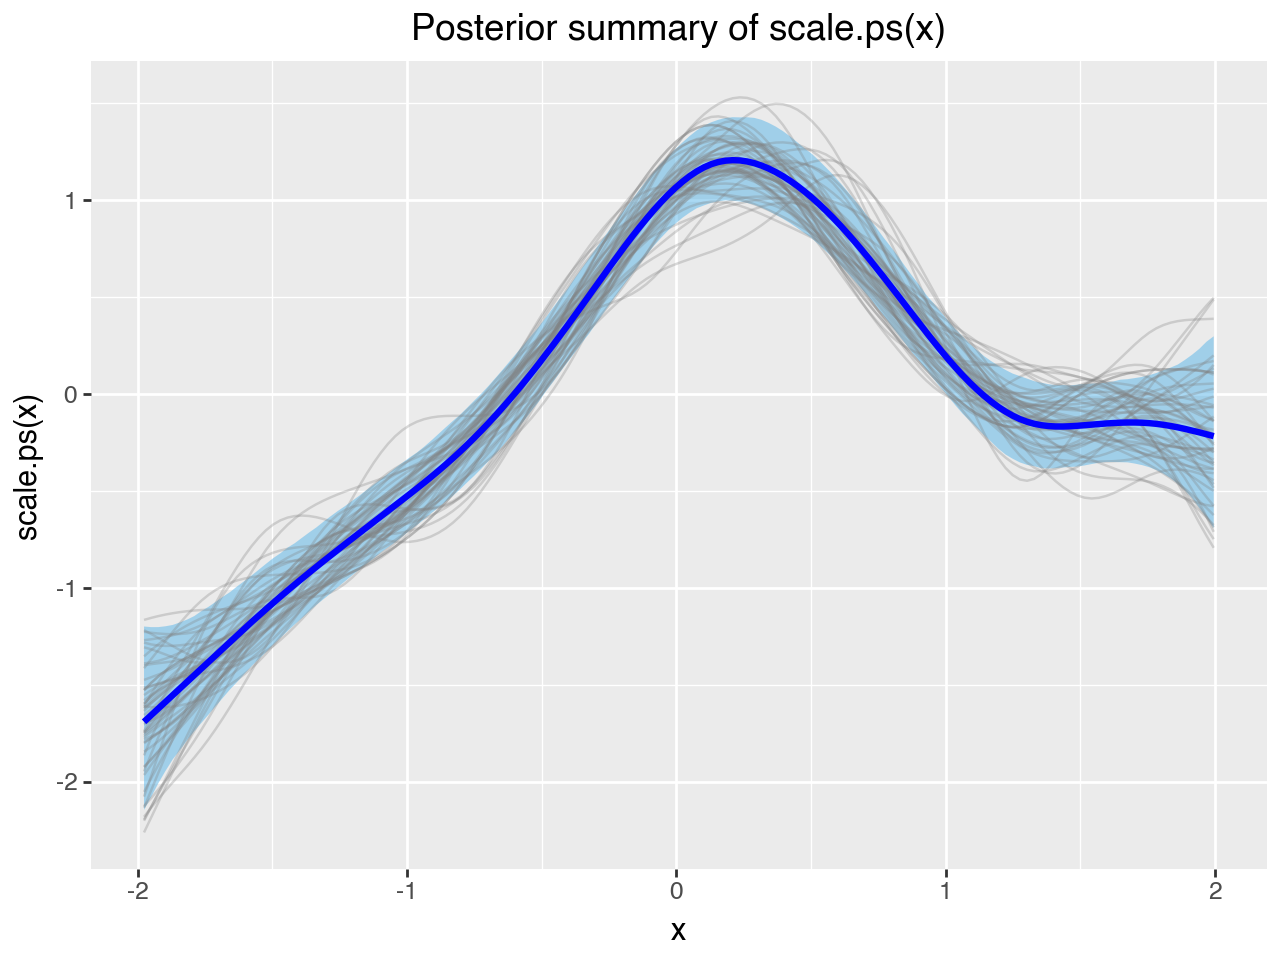

In [72]:
gam.plot_1d_smooth(term=model.vars["scale.ps(x)"], samples=samples)

### Predict variables at new x values

In [73]:
x_grid = jnp.linspace(df.x.min(), df.x.max(), 300)

predictions = model.predict(
    samples=samples,
    predict=["loc.ps(x)", "scale.ps(x)", "loc", "scale"],
    newdata={"x": x_grid},
)

predictions_summary = gs.SamplesSummary(predictions).to_dataframe().reset_index()
predictions_summary["x"] = np.tile(x_grid, len(predictions))

### Plot parameters as functions of covariate

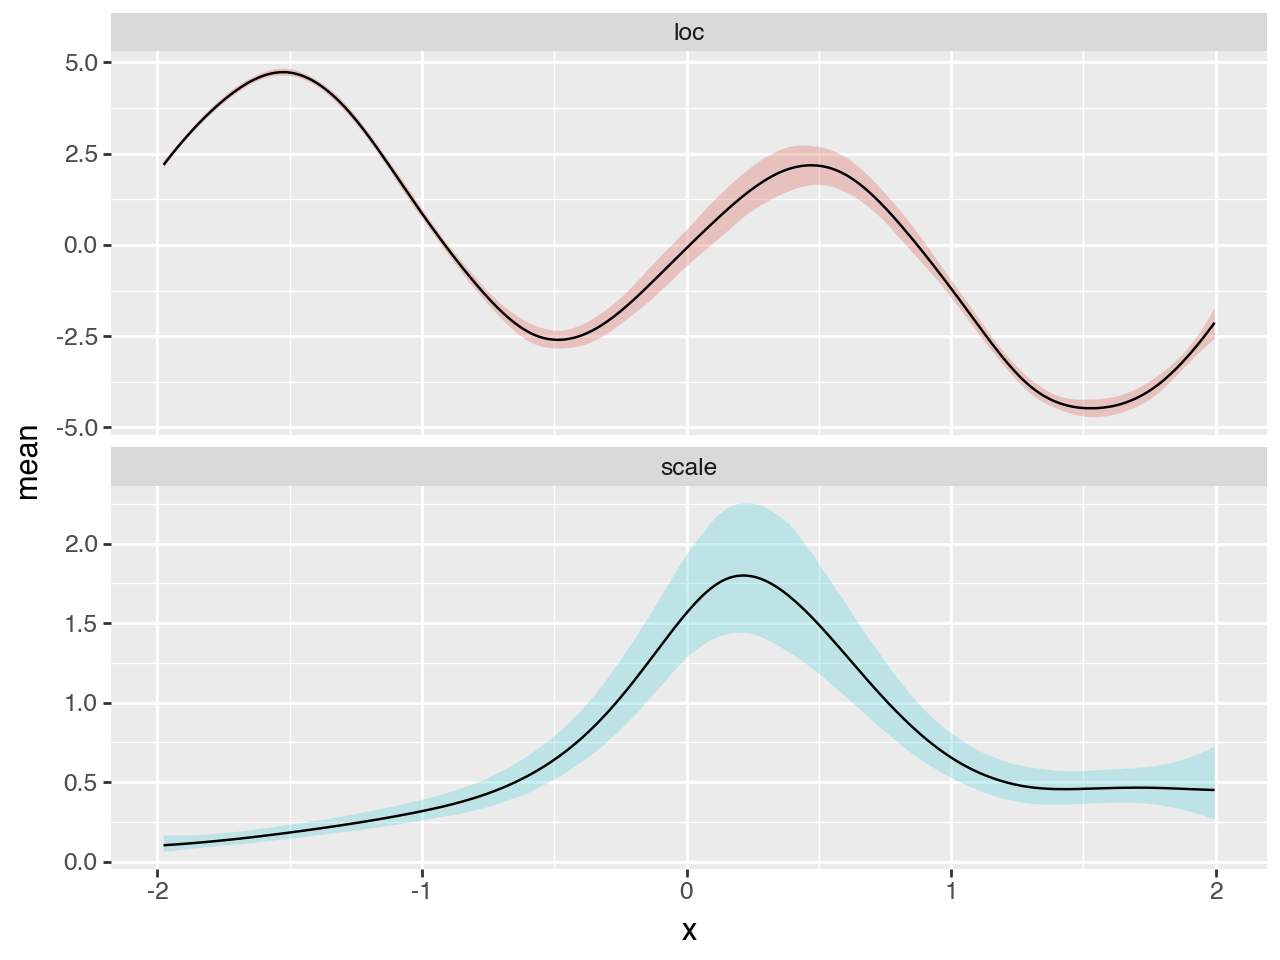

In [74]:
select = predictions_summary["variable"].isin(["loc", "scale"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot fitted location with raw data

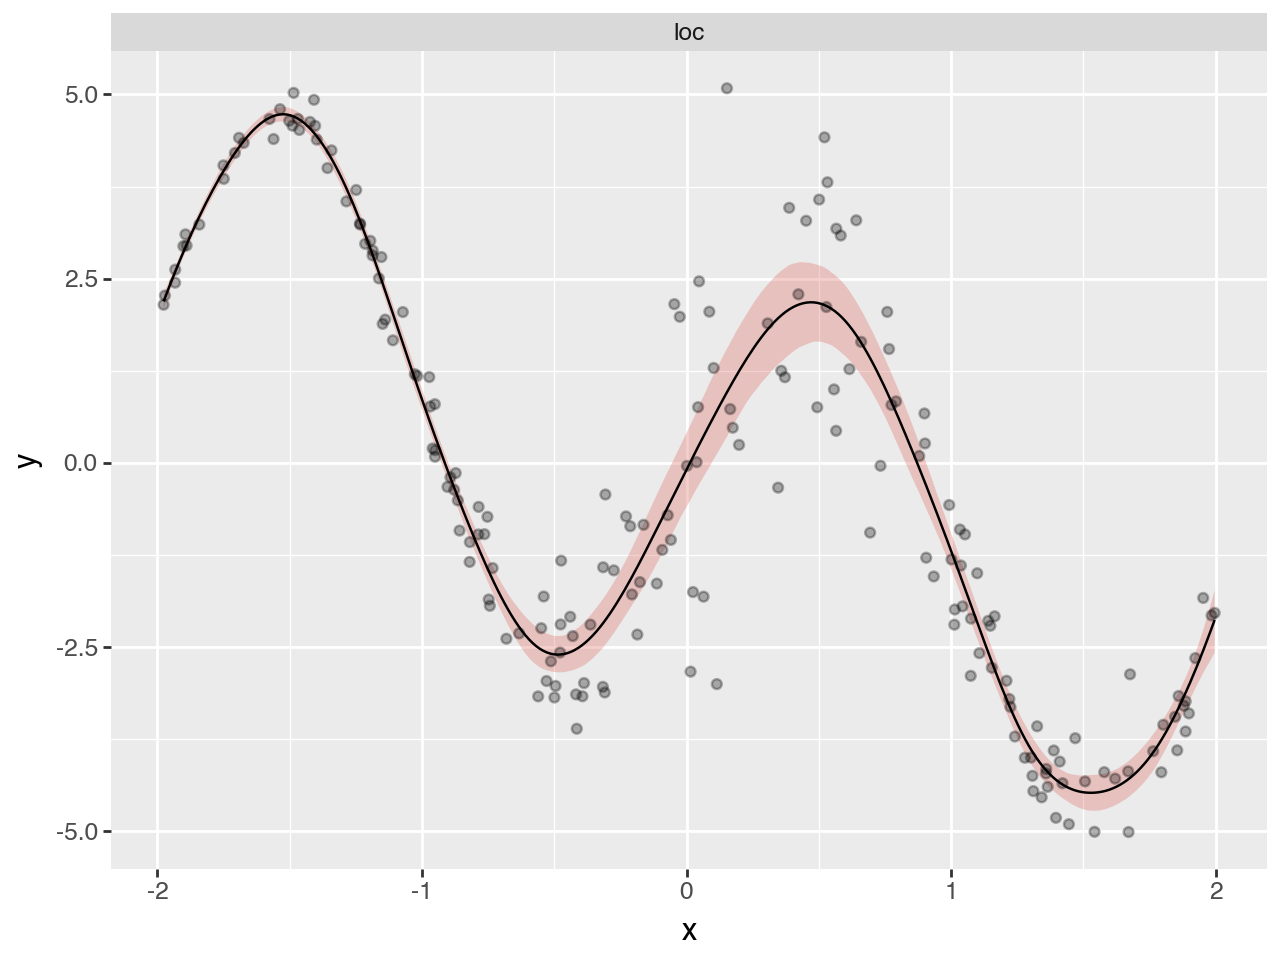

In [75]:
select = predictions_summary["variable"].isin(["loc"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Posterior predictive distribution

In [76]:
select = predictions_summary["variable"].isin(["loc", "scale"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["loc"] - mu_sigma_df["scale"]
mu_sigma_df["high"] = mu_sigma_df["loc"] + mu_sigma_df["scale"]
mu_sigma_df

variable,x,loc,scale,low,high
0,-1.976702,2.192143,0.102965,2.089178,2.295108
1,-1.963415,2.317238,0.104393,2.212845,2.421630
2,-1.950128,2.439796,0.105870,2.333926,2.545667
3,-1.936841,2.559781,0.107398,2.452383,2.667178
4,-1.923554,2.677188,0.108975,2.568213,2.786163
...,...,...,...,...,...
295,1.942956,-2.635680,0.452966,-3.088646,-2.182714
296,1.956243,-2.513725,0.452268,-2.965993,-2.061456
297,1.969530,-2.388815,0.451673,-2.840488,-1.937142
298,1.982817,-2.261085,0.451194,-2.712279,-1.809891


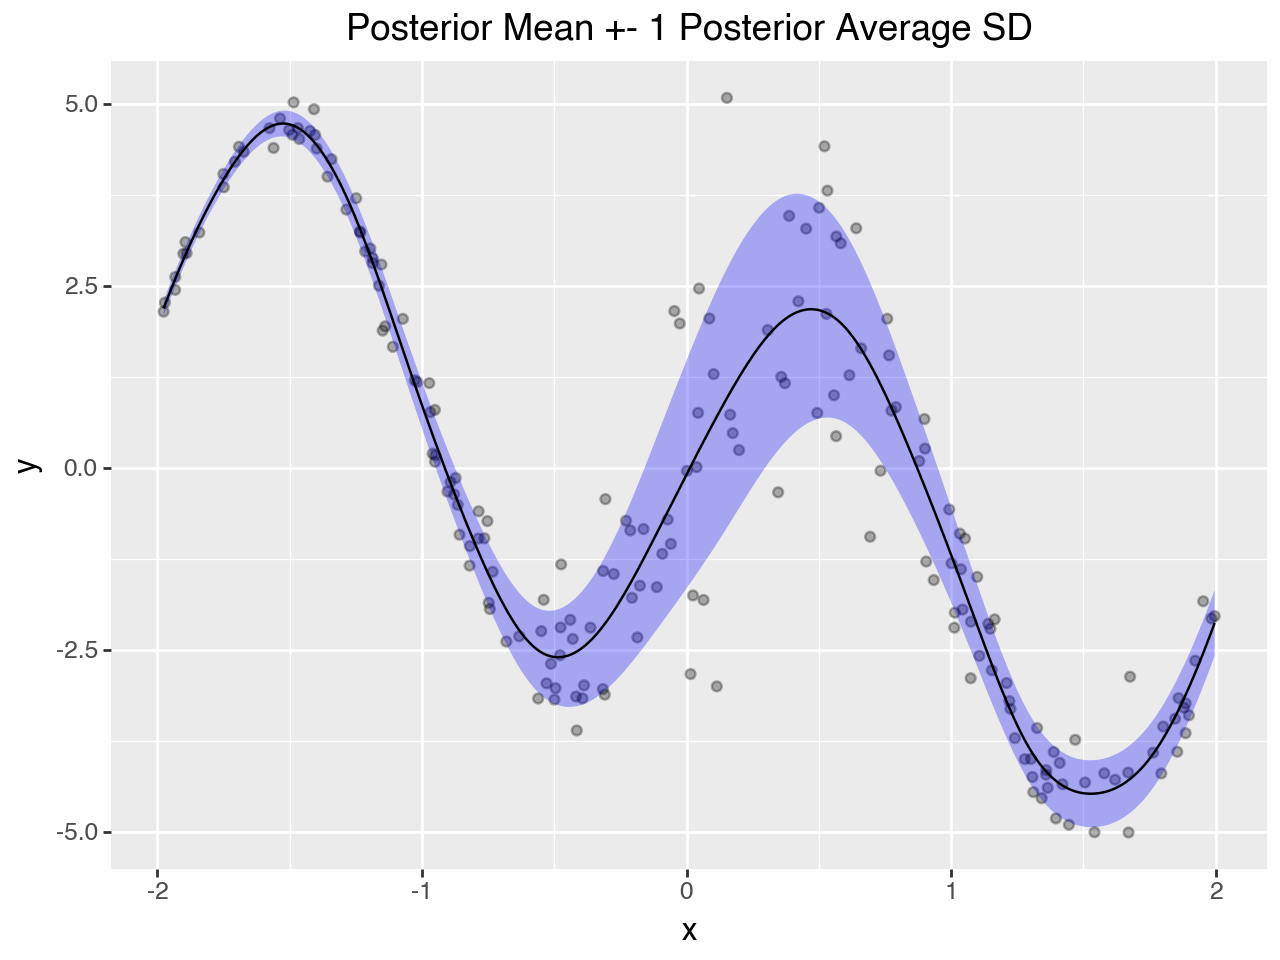

In [77]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "loc"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

### Sample from posterior predictive distribution

In [78]:
import jax

ppsamples = model.sample(shape=(), seed=jax.random.key(1), posterior_samples=samples)

ppsamples["y"].shape

(4, 1000, 200)

In [79]:
# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

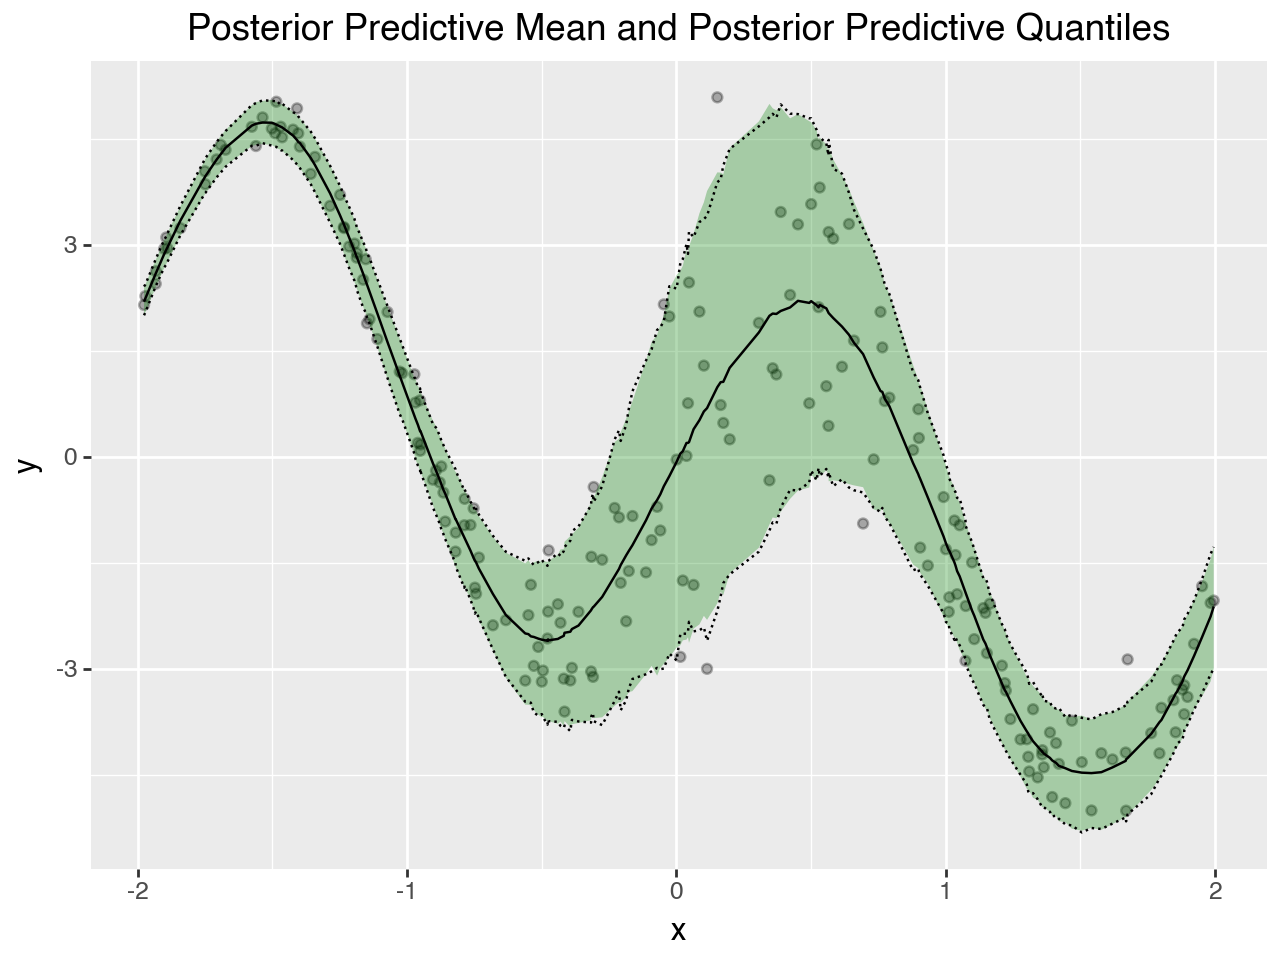

In [80]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)